# TODOs

- [ ] When hitting restart(). Maybe do so from the state we left off at. Though it shoudlnt matter as much
- [ ] Train with random initial selection of sampling rates
- [ ] Change initial state. Could help with removing 0s
- [ ] Maybe add batching (if necessary)
- [ ] Add current decimation rate extending the state from $\text{numStates} + 1$ to $\text{numStates} + 2$
- [ ] Change Adam to RMSProp
- [ ] Change the Policy Slower than the value funciton
- [ ] Judge how close we are to $\max_{i: i=j} P_\Delta(i,j)$
- [ ] Change step from spawning a new chain to just continuing the same one from before. 

# Introduction

This notebook will change from the previous in that we will not have all possible action decimation rates available but lets say something along the lines of multiples. i.e. 1,2,4,8.

We will also include the action in the state tape. So that it knows how fast it is going.

Will probably also add replay memory

In [1]:
# Add path forimporting
import sys
sys.path.append('../../')

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from time import time
import torch.nn.functional as F
from sp_sims.simulators.stochasticprocesses import BDStates
from samprecon.environments.Environments import MarkovianUniformCumulativeEnvironment
from samprecon.samplers.agents import SoftmaxAgent 
from samprecon.reconstructors.NNReconstructors import RNNReconstructor
from samprecon.utils.rl_utils import calculate_returns
from samprecon.feedbacksigs.feedbacks import Reconstructor
from samprecon.estimators.value_estimators import SequenceValue,ValueFunc
from tqdm.notebook import tqdm
from torch import nn
import torch

# Send random seeds
np.random.seed(0)
torch.manual_seed(0)

# Initialize context first
device = "cpu"
# Check for Mac M1 and Cuda
if torch.cuda.is_available():
    device = "cuda:0"
    print("Running on GPU")
elif "arm64" in sys.version.lower():
    device = "mps"
    print("Running on Mac M1")
# for debugging 🐛
#device = "cpu"

plt.style.use('rose-pine-dawn')
rnd.seed(int(time()))
%load_ext autoreload
%autoreload 2

Running on GPU


In [2]:
# Generate Environments on which to learn
high_res_delta = 1e-0  # For generating the dataset and later sample
baseline_rates = {"lam": 1 / 10, "mu": 4 / 10}
epochs = 2000
length_of_episode = 15
step_path_length = 1
sampling_budget = 16
epochs_b4_policy_update = 1
value_learning_rate = 1e-2
policy_learning_rate = 1e-3
batch_size = 4
#used_path_length = 64  # So that we can let the process reach stationarity and take samples from stationary distribution
num_states = 4
avg_span = np.mean(1 / np.array(list(baseline_rates.values())))
max_decimation = (
    avg_span / high_res_delta
) * 4  # Max decimation factor #CHECK: Maybe not divide by 2
decimation_steps = [-8,-4,-2,-1,0,1,2,4,8]
# Easier
#current_decimation_factor = torch.LongTensor(
#    [int(avg_span // high_res_delta)]
#).to(device)
# Harder
current_decimation_factor = torch.randint(1, int(max_decimation), (1,))

print(f"Decimation factor is {current_decimation_factor}")
# Set random seed with time for randomnessj

Decimation factor is tensor([21])


# Declarations

In [3]:
state_generator = BDStates(baseline_rates, high_res_delta, num_states)
# sampling_arbiter.initialize_grad_hooks()
reconstructor = RNNReconstructor(
    amnt_states=num_states, max_decimation_rate=max_decimation
).to(device)
recon_feedback = Reconstructor(num_states,reconstructor, nn.NLLLoss(reduction='none') )
#reconstructor.initialize_grad_hooks()
#valueEst = SequenceValue(num_states+1,1).to(device)
valueEst = ValueFunc(sampling_budget+1, 1).to(device)
gamma = 0.9

# RL Loop

In [12]:
import copy

env = MarkovianUniformCumulativeEnvironment(
    state_generator=state_generator,
    feedback=recon_feedback,
    starting_decrate=current_decimation_factor,
    max_decimation = max_decimation,
    sampling_budget=sampling_budget,
)
ebar = tqdm(range(epochs), desc="Epochs", position=0)
sampling_agent = SoftmaxAgent(sampling_budget+1, len(decimation_steps)).to(device)# +1 for the decimation factor
# sampling_agent.initialize_grad_hooks()
optimizer_policy = torch.optim.Adam(
    list(reconstructor.parameters())
    + list(sampling_agent.parameters()),
    lr=policy_learning_rate,
)
optimizer_value_est = torch.optim.Adam(valueEst.parameters(), lr=value_learning_rate)
t_decsteps = torch.LongTensor(decimation_steps).to(device)
# val_opt = torch.optim.Adam(valueEst.parameters(), lr=1e-2)

# Scheduler with warmpu
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
e_returns = []
est_loss = []
val_losses = []
reconstructor_last_weights = list(reconstructor.state_dict().values())
value_last_weights = list(valueEst.state_dict().values())
sampler_last_weights = list(sampling_agent.state_dict().values())
sbar = tqdm(range(length_of_episode), desc="Steps", leave=True, position=1)
for epoch in range(epochs):
    # We generate a single step from the generator process
    regrets = []
    log_probs = []
    val_ests = []
    sbar.reset()

    current_decimation_factor = torch.randint(1, int(max_decimation), (batch_size,1)).to(device)

    init_states = torch.randint(0, num_states, (batch_size,1)).to(device)

    # Initial State
    sampled_tape, fullres_tape = env.reset(current_decimation_factor, init_states)
    states = [
        torch.cat(
            (
                current_decimation_factor,
                sampled_tape
            ),
            dim=-1,
        )
    ]
    # TODO: randomly select current_decimation_factor within some bounds
    for step in range(length_of_episode):
        # with torch.autograd.set_detect_anomaly(True):
        cur_state = states[-1].to(torch.float)
        action_probs = sampling_agent.act(cur_state)
        #print("Action probs are", action_probs)
        action_probs = action_probs.to(device)
        dist = torch.distributions.Categorical(action_probs)

        sampled_action = (dist.sample()).to(
            device
        )  # So as to not sample 0 (and end up dividing by zero)
        
        # pick from decimation_steps with indices specified in sampled_action
        #current_decimation_factor += 
        selected_actions = t_decsteps[sampled_action].view(-1,1).to(device)
        #current_decimation_factor = torch.clamp(current_decimation_factor + selected_actions, 1, int(max_decimation))
        
        # CHECK: Do we need this?
        #dec_steps = (
        #    torch.arange(
        #        0,
        #        current_decimation_factor.item() * sampling_budget,
        #        current_decimation_factor.item(),
        #    )
        #    .view(-1, 1)
        #    .to(device)
        #)
        #one_hot_cur_state = F.one_hot(
        #    cur_state[0,1:sampling_budget+1].to(torch.long), num_classes=num_states
        #).to(device)
        #non_amb_state = (
        #    torch.cat((one_hot_cur_state, dec_steps), dim=-1).to(torch.float).to(device)
        #).view(1,sampling_budget,-1)
        val_ests.append(valueEst(cur_state).to(device))

        new_state, regret, done = env.step(cur_state.to(torch.long), selected_actions)

        states.append(new_state.to(device))
        regrets.append(regret)
        log_probs.append(dist.log_prob(sampled_action))

        #sbar.set_description(f"At step {step}, Regret: {regret}")
        #sbar.update(1)

    regrets = torch.stack(regrets).T

    log_probs = torch.stack(log_probs).T 
    val_ests = torch.cat(val_ests, dim=-1)
    returns = calculate_returns(regrets, gamma)

    e_returns.append(returns[:,0].mean().item()) # For logging mostly
    policy_regrets = []
    value_loss = []

    # TODO: add in batches
    k = 0
    for lp, val_est, r in zip(log_probs[:,:3].T, val_ests[:,:3].T, returns[:,:3].T):
        disadvantage = r - val_est.detach() # Need detach otherwise we get double backprop error
        policy_regrets.append(
            -lp * disadvantage
        )  # TODO: this might require a negative sign
        #value_loss.append(
        #    F.mse_loss(val_est, torch.Tensor([r.item()]).view(1, -1).to(device))
        #)

        # Change the value estimation to TD learning
        current_value_est = val_est
        next_value = val_ests[:,k+1]
        target = r + gamma * next_value
        value_loss.append(
            F.mse_loss(current_value_est, target.detach())
        )

        k+=1
    # We update the whole thingko
    policy_loss = torch.stack(policy_regrets).sum()
    value_loss = torch.stack(value_loss).mean()

    val_losses.append(value_loss.item())

    # optimze:
    optimizer_policy.zero_grad()
    optimizer_value_est.zero_grad()
    if epoch % epochs_b4_policy_update == 0:
        policy_loss.backward()
        optimizer_policy.step()
    value_loss.backward()
    optimizer_value_est.step()
    #scheduler.step()

    # 🐛 Debugging
    #differences = []
    #for i, v in enumerate(sampling_agent.state_dict().values()):
    #    differences.append(torch.sum(torch.abs(v - sampler_last_weights[i])))
    #differences_arbitrer = torch.sum(torch.tensor(differences))
    ## hard copy last weights
    #sampler_last_weights = [
    #    copy.deepcopy(v) for v in sampling_agent.state_dict().values()
    #]
    #differences = []
    #for i, v in enumerate(reconstructor.state_dict().values()):
    #    differences.append(torch.sum(torch.abs(v - reconstructor_last_weights[i])))
    #differences_recon = torch.sum(torch.Tensor(differences))
    #reconstructor_last_weights = [
    #    copy.deepcopy(v) for v in reconstructor.state_dict().values()
    #]
    #differenes = []
    #for i,v in enumerate(valueEst.state_dict().values()):
    #    differences.append(torch.sum(torch.abs(v - value_last_weights[i])))
    #differences_value = torch.sum(torch.Tensor(differences))
    #value_last_weights = [
    #    copy.deepcopy(v) for v in valueEst.state_dict().values()
    #]
    #print(
    #    f"Differences are : Sampler: {differences_arbitrer}, Reconstrctor: {differences_recon}, Value Estimator: {differences_value}"
    #)

    # 🐛 End Debuggin

    moving_avg_loss = np.mean(e_returns[-3:]) if epoch > 3 else np.mean(e_returns)
    ebar.set_description(f"Epoch Mean Regret: {moving_avg_loss}")
    ebar.update(1)
    # We get reward based on how close we got to maximum information
# Show Losses
fig,axs = plt.subplots(1,2, figsize=(20,5))
axs[0].set_title("Average (actual) Reconstruction Regret")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss (NLL)")
axs[0].plot(e_returns)

axs[1].set_title("Value Estimation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss (MSE)")
axs[1].plot(val_losses)

plt.show()

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Steps:   0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Get time in nice format
from datetime import datetime
now = datetime.now()
date_time  = now.strftime("%m-%d-%Y_%H-%M-%S")

# SaveModels 
torch.save(reconstructor.state_dict(), f"models/reconstructor_{date_time}.pt")
torch.save(sampling_agent.state_dict(), f"models/sampling_agent_{date_time}.pt")

RuntimeError: Parent directory models does not exist.

Example number 0
Lenght of final state is 16


NameError: name 'final_state' is not defined

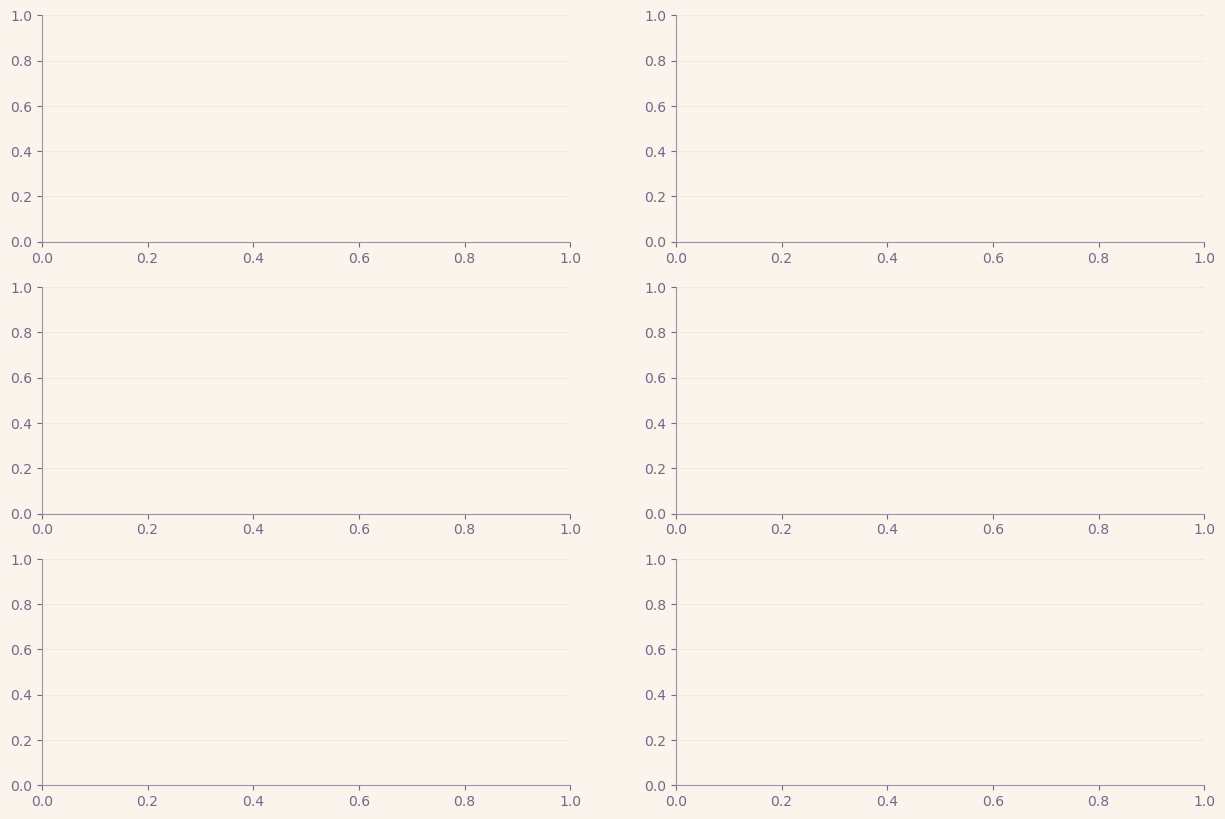

In [ ]:
from samprecon.samplers.spatial_transformers import differentiable_uniform_sampler
from samprecon.utils.utils import dec_rep_to_batched_rep, setup_logger

def hard_decimation_of_state(high_freq_signal: torch.Tensor, rate: int, sampling_budget:int, num_classes:int):
    blank_slate = torch.zeros_like(high_freq_signal)
    seq_len = len(blank_slate)
    samples = high_freq_signal[::rate][:sampling_budget]
    for i,sample in enumerate(samples):
        blank_slate[i*rate] = sample
    # turn blank_slate into one hot
    one_hot = F.one_hot(blank_slate.to(torch.long), num_classes=num_classes).view(1,-1,num_classes)
    return one_hot


sampling_agent.eval()
reconstructor.eval()

chosen_actions = []

# Visually confirm proper reconstruction. 
num_examples = 3

fig, axs = plt.subplots(num_examples,2, figsize=(15,10))
# Start with some previous state. 


for ne in range(num_examples):

    regrets = []
    val_ests = []
    sbar.reset()

    actions_taken = []

    current_decimation_factor = torch.randint(1, int(max_decimation), (1,)).to(device)
    decimation_rates = []

    init_states = torch.randint(0, num_states, (1,)).to(device)
    sampled_tape, fullres_tape = env.reset(current_decimation_factor, init_states)
    # Initial State
    states = [
        torch.cat(
            (
                current_decimation_factor.view(-1,1),
                sampled_tape,
            ),
            dim=-1,
        )
    ]

    for step in range(length_of_episode):
        # with torch.autograd.set_detect_anomaly(True):
        cur_state = states[-1]
        action_probs = sampling_agent.act(cur_state.to(torch.float))# CHECK why smapling_budget + 2
        #print("Action probs are", action_probs)
        action_probs = action_probs.to(device)
        sampled_action = torch.argmax(action_probs,dim=-1)

        actions_taken.append(sampled_action.item())
        
        # CHECK: If we should have computation graph *not* cutting here
        current_decimation_factor += decimation_steps[sampled_action.item()]
        current_decimation_factor = torch.LongTensor([int(max(1,min(current_decimation_factor, max_decimation)))]).to(device)
        decimation_rates.append(current_decimation_factor.item())
        
        # TODO: tensorize
        new_state, regret, done = env.step(cur_state,sampled_action)


        states.append(new_state)
        regrets.append(regret)

        sbar.set_description(f"At step {step}, Regret: {regret}")
        sbar.update(1)

    final_action = torch.argmax(sampling_agent.act(states[-1].to(torch.float)),dim=-1)
    final_dec_factor = current_decimation_factor.item() + final_action
    sampled_tape, fullres_tape = env.state_generator.sample(final_dec_factor.view(1,1), sampling_budget, states[-1][:,-1].view(1,1))
    final_state_oh = F.one_hot(sampled_tape.view(1, -1).to(torch.long), num_classes=state_generator.max_state).float()

    #final_dec_state = hard_decimation_of_state(final_state, final_dec_factor, sampling_budget, num_states)
    #final_dec_state = differentiable_uniform_sampler(final_state_oh, final_dec_factor)

    print(f"Example number {ne}")
    oh_fullres_sig = dec_rep_to_batched_rep(sampled_tape, final_dec_factor, sampling_budget,num_states, add_position=False)
    final_sm = F.softmax(reconstructor(oh_fullres_sig),dim=-1)
    final_reconstruction = torch.argmax(final_sm,dim=-1).cpu().detach().numpy().squeeze()

    final_state = fullres_tape.cpu().detach().numpy().squeeze()
    final_dec_state = sampled_tape.cpu().detach().numpy().squeeze()
    final_dec_factor = final_dec_factor.cpu().detach().numpy().squeeze()

    print(f"Lenght of final state is {len(final_state)}")

    # Do plotting here
    entire_x = np.arange(0,high_res_delta*(len(final_state)),step=high_res_delta)
    axs[ne,0].plot(entire_x, final_state,drawstyle="steps-post",label="Full resolution")#, marker="^",markersize=3)
    # Plot Samples
    dec_x = np.arange(0,(sampling_budget*final_dec_factor),step=final_dec_factor)
    axs[ne,0].scatter(dec_x, finaal_dec_state, label="Decimated", marker="o",color='r',s=30)
    axs[ne,0].set_title(f"Results for Experiment {ne+1}")

    # Plot Reconstrunction
    axs[ne,0].plot(entire_x, final_reconstruction, label="Reconstruction")#, marker="x",markersize=3)
    axs[ne,0].legend()

    # History of Actions
    axs[ne,1].plot(np.arange(len(decimation_rates)),decimation_rates)
    axs[ne,1].set_title("History of Actions (Decimation Rates)")
plt.tight_layout()
plt.show()
    
print(f"Choices of actions were {chosen_actions}")